In [1]:
from pathlib import Path
import json
import pandas as pd
import spacy
from statistics import mean, median

In [2]:
spacy_model = spacy.load('ro_core_news_lg')

In [3]:
ROOT = Path("../../data-cleaned")

# Top-level groups we care about
GROUPS = ["int", "int_istoric", "judete", "raioane"]

# Which JSON key holds the text
CONTENT_KEY = "content"

# Output CSVs
OUT_SENTENCE = "sentence_word_counts.csv"
OUT_FILE_SUM = "file_sentence_stats.csv"

In [4]:
if "parser" not in spacy_model.pipe_names and "sentencizer" not in spacy_model.pipe_names:
    spacy_model.add_pipe("sentencizer")

In [6]:
def iter_target_files(root: Path):
    """Yield (group, rel_path, abs_path) for JSON files under:
       - int/
       - int_istoric/
       - judete/<regiune>/...
       - raioane/
    """
    # 1. int
    for fp in (root / "int").rglob("*.json"):
        yield "int", fp.relative_to(root).as_posix(), fp

    # 2. int_istoric
    for fp in (root / "int_istoric").rglob("*.json"):
        yield "int_istoric", fp.relative_to(root).as_posix(), fp

    # 3. Each subfolder of judete = its own group
    judete_root = root / "judete"
    if judete_root.exists():
        for county_dir in judete_root.iterdir():
            if county_dir.is_dir():
                county = county_dir.name
                for fp in county_dir.rglob("*.json"):
                    yield county, fp.relative_to(root).as_posix(), fp

    # 4. All raioane together
    for fp in (root / "raioane").rglob("*.json"):
        yield "raioane", fp.relative_to(root).as_posix(), fp

In [10]:
def safe_load_content(fp: Path, key=CONTENT_KEY):
    try:
        obj = json.loads(fp.read_text(encoding="utf-8"))
        text = obj.get(key, "")
        return text if isinstance(text, str) else ""
    except Exception:
        return ""
    
def count_words_in_sent(sent):
    # Count alphabetic tokens only (ignores punctuation/numbers)
    return sum(1 for t in sent if t.is_alpha)
    

In [12]:
# Collect metadata and texts for batch processing
records = []   # to batch into nlp.pipe
meta = []      # parallel metadata for each text

for subgroup, rel, fp in iter_target_files(ROOT):
    text = safe_load_content(fp, CONTENT_KEY)
    meta.append((subgroup, rel))
    records.append(text)

sentence_rows = []  # rows for sentence-level CSV
file_summary = []   # rows for file-level stats

In [ ]:
for (subgroup, rel), doc in zip(meta, spacy_model.pipe(records, batch_size=50)):
    # Build per-sentence counts
    counts = []
    for i, sent in enumerate(doc.sents):
        wcount = count_words_in_sent(sent)
        counts.append(wcount)
        sentence_rows.append({
            "subgroup": subgroup,          
            "relative_path": rel,   
            "sentence_index": i,
            "words_in_sentence": wcount
        })

    # Per-file stats (handle empty gracefully)
    if counts:
        file_summary.append({
            "subgroup": subgroup,
            "relative_path": rel,
            "num_sentences": len(counts),
            "min_words_per_sentence": min(counts),
            "avg_words_per_sentence": round(mean(counts), 3),
            "median_words_per_sentence": float(median(counts)),
            "max_words_per_sentence": max(counts),
        })
    else:
        file_summary.append({
            "subgroup": subgroup,
            "relative_path": rel,
            "num_sentences": 0,
            "min_words_per_sentence": 0,
            "avg_words_per_sentence": 0.0,
            "median_words_per_sentence": 0.0,
            "max_words_per_sentence": 0,
        })

Saved:
 - sentence_word_counts.csv
 - file_sentence_stats.csv


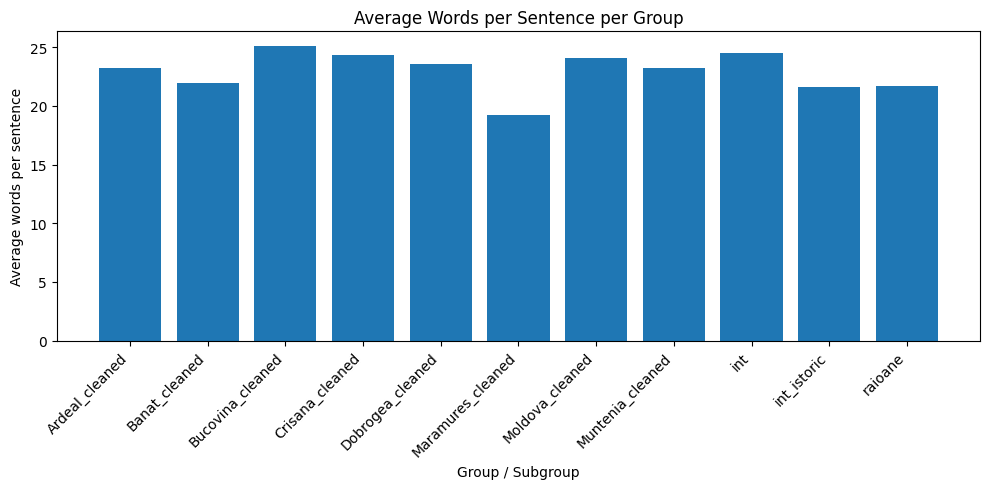

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df_sent = pd.DataFrame(sentence_rows)

# compute average words per sentence per (subgroup)
avg_per_group = df_sent.groupby("subgroup")["words_in_sentence"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.bar(avg_per_group["subgroup"], avg_per_group["words_in_sentence"])
plt.title("Average Words per Sentence per Group")
plt.xlabel("Group / Subgroup")
plt.ylabel("Average words per sentence")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

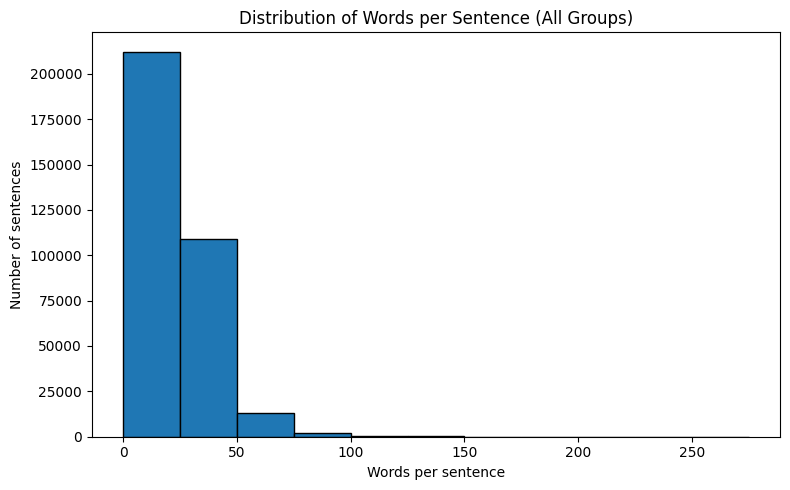

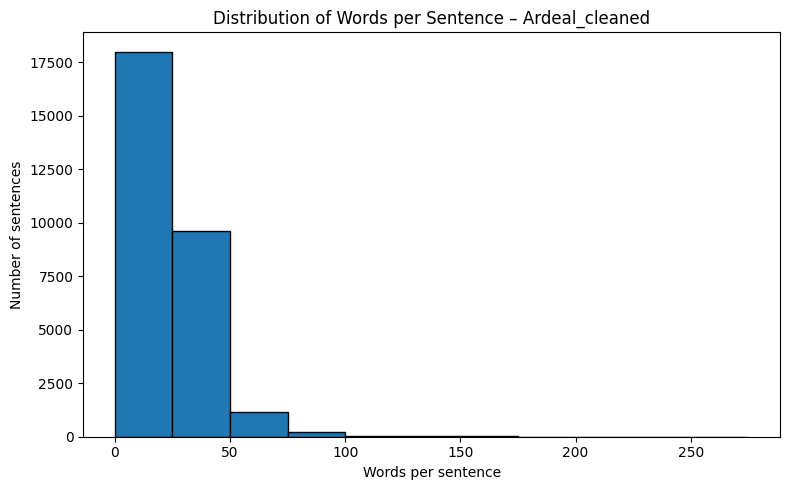

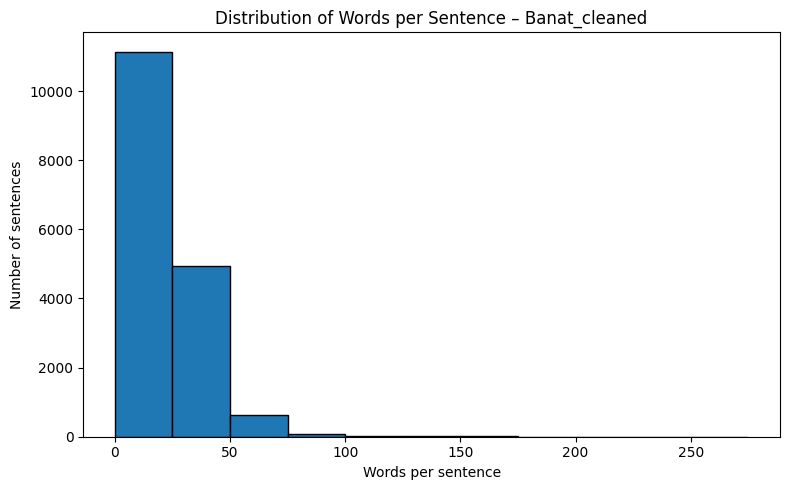

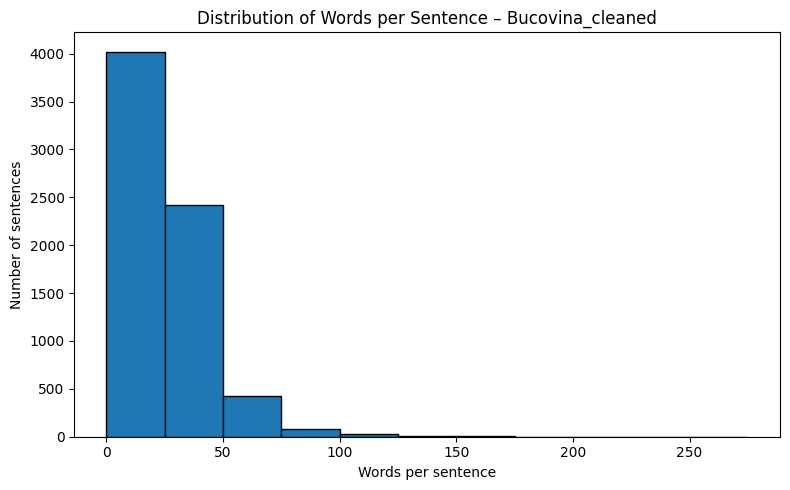

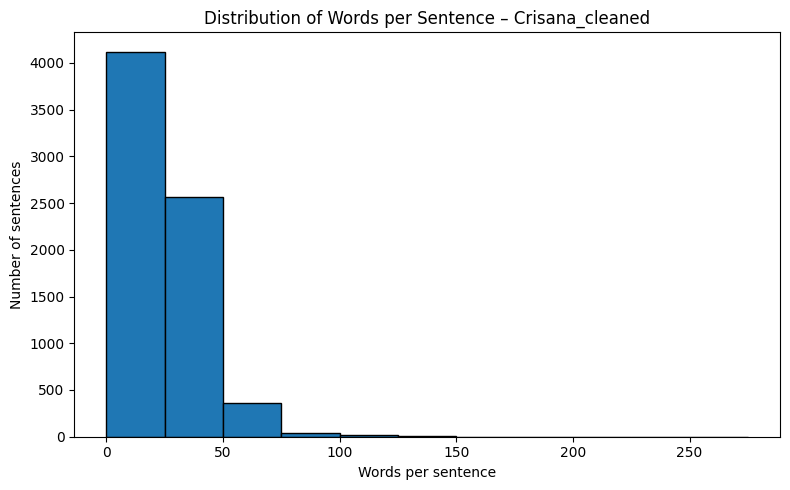

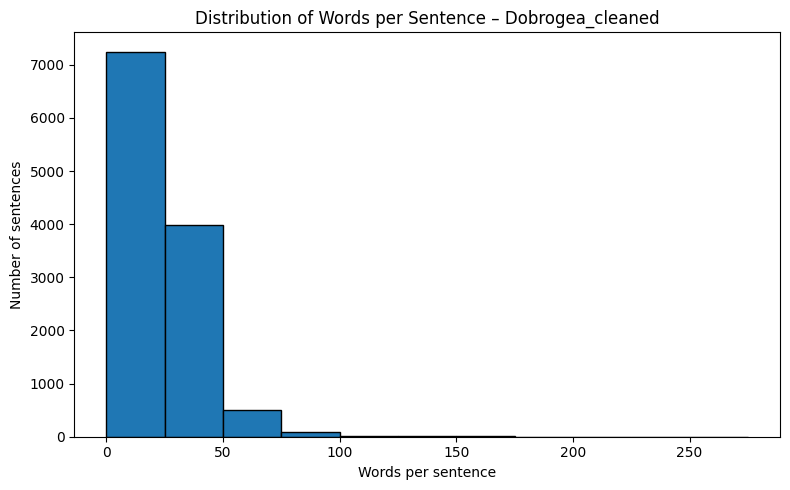

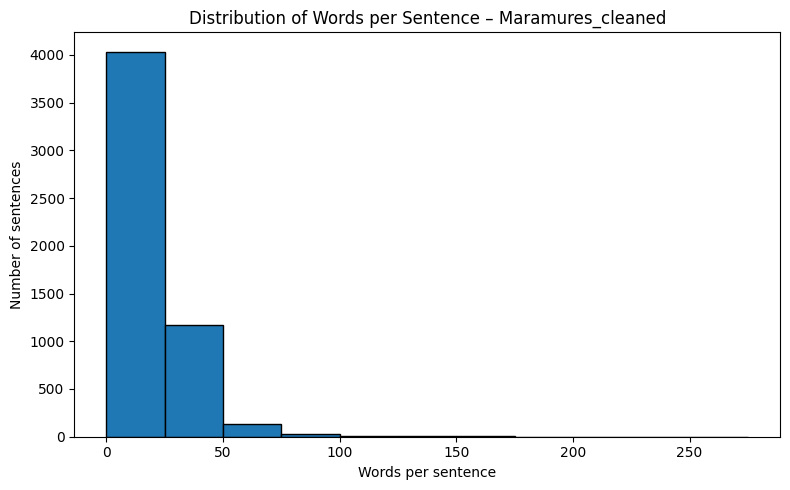

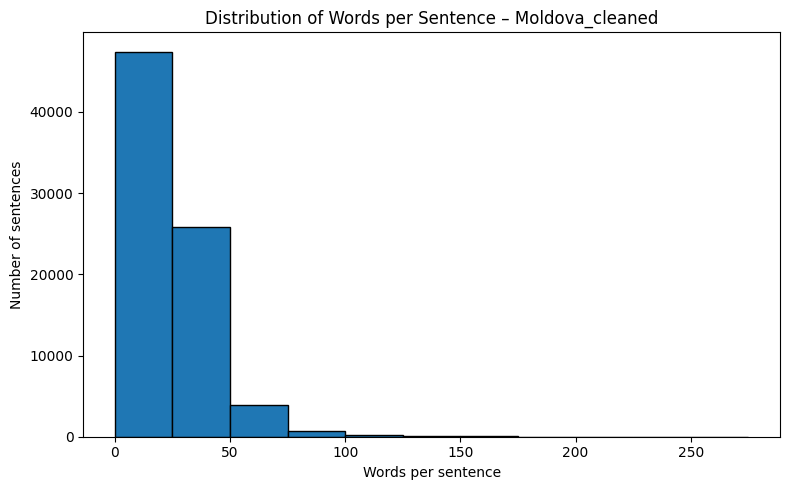

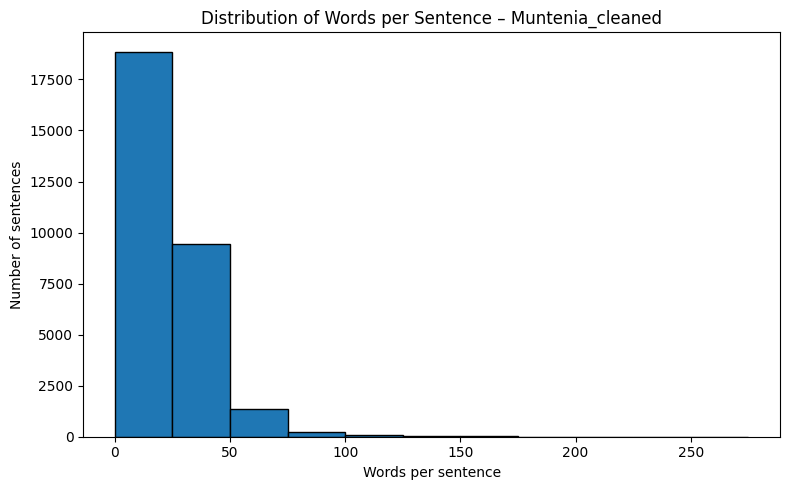

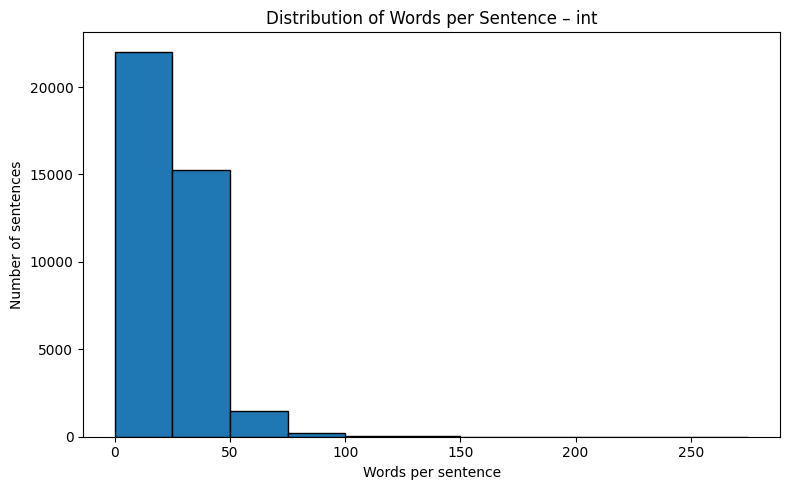

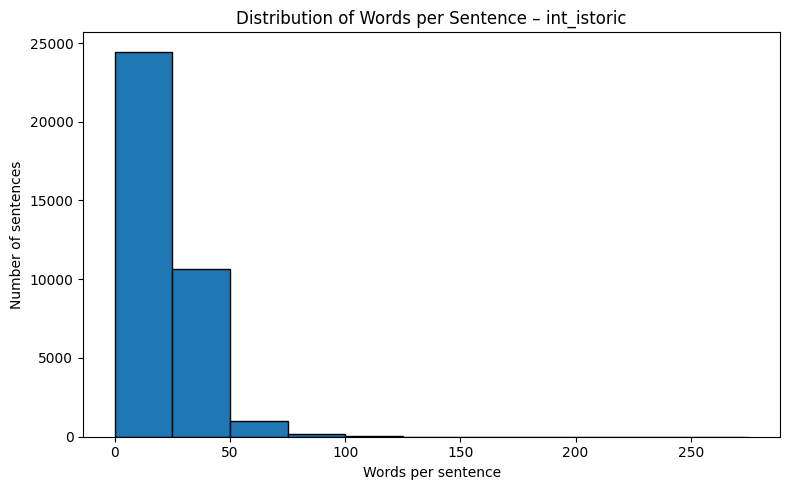

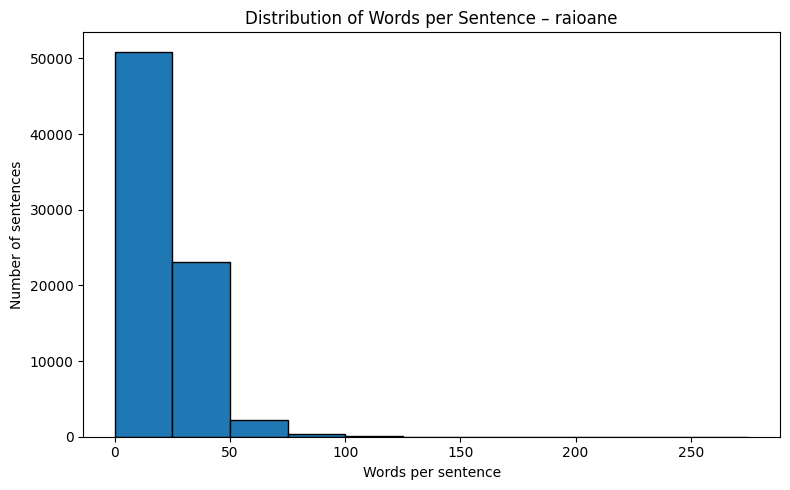

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_sent = pd.DataFrame(sentence_rows)

# --- Global distribution ---
plt.figure(figsize=(8,5))
plt.hist(df_sent["words_in_sentence"], bins=range(0, 300, 25), edgecolor="black")
plt.title("Distribution of Words per Sentence (All Groups)")
plt.xlabel("Words per sentence"
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.show()
    
# --- Per-group distributions ---
for grp, subdf in df_sent.groupby("subgroup"):
    plt.figure(figsize=(8,5))
    plt.hist(subdf["words_in_sentence"], bins=range(0, 300, 25), edgecolor="black")
    plt.title(f"Distribution of Words per Sentence – {grp}")
    plt.xlabel("Words per sentence")
    plt.ylabel("Number of sentences")
    plt.tight_layout()
    plt.show()
